# Testing DeepER

### Import libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data

Using TensorFlow backend.


### Read the dataset

In [2]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    'Walmart_Amazon', baseDir = '../input/deeper/deeper', maxSequenceLength=100)

Printing out words with no embeddings in GloVe

In [3]:
PRINT_RANGE = 30

if len(wordsWithNoEmbeddings) < PRINT_RANGE:
    PRINT_RANGE = len(wordsWithNoEmbeddings)

if PRINT_RANGE > 0:   
    for i in range(PRINT_RANGE):
        print(wordsWithNoEmbeddings[i])

print('...')
print("There are {} words with no embeddings in GloVe".format(len(wordsWithNoEmbeddings)))

innovera
v7n3c5e
filemate
roocase
xantech
simplism
amzer
v7n2c6
m315
sabrent
t020201
holoscreen
m530
m531
tu2
tn360
drivestation
ce278a
96438
03f
tg4022n
6400c5
grys
ce505xd
diskgo
m552
tn110bk
vmax2
t060320
tn450
...
There are 5369 words with no embeddings in GloVe


Print embedding matrix shape

In [4]:
embeddingMatrix.shape

(11468, 300)

In [5]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

Print training set size

In [6]:
print(leftTableTrainData.shape)
print(rightTableTrainData.shape)

(6144, 100)
(6144, 100)


Print test set size

In [7]:
print(leftTableTestData.shape)
print(rightTableTestData.shape)

(2049, 100)
(2049, 100)


Print validation set size

In [8]:
print(leftTableValData.shape)
print(rightTableValData.shape)

(2049, 100)
(2049, 100)


### Build the DeepER model 

In [9]:
model = build_model(embeddingMatrix, lstmUnits=75, lstm_dropout=0.1, mask_zero=True, maxSequenceLength=100)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3440400     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150)          225600      embedding_1[0][0]                
          

### Plot DeepER architecture

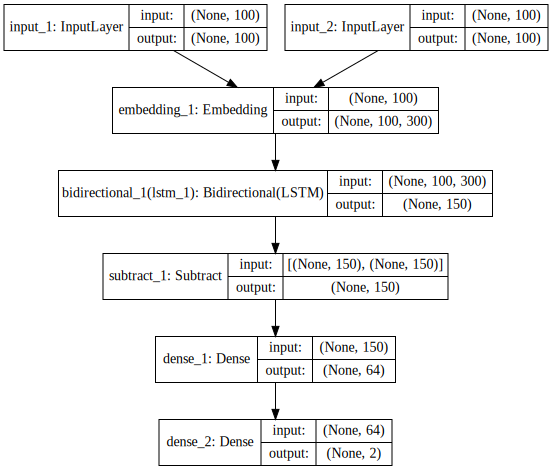

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [11]:
start_time = time.time()

history = model.fit([leftTableTrainData,
           rightTableTrainData],
          trainLabels,
          batch_size=256,
          epochs=20,
          validation_data=([leftTableValData,
                            rightTableValData],
                           valLabels))

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Train on 6144 samples, validate on 2049 samples
Epoch 1/20
6144/6144 [==============================] - 27s 4ms/step - loss: 0.4633 - acc: 0.7922 - val_loss: 0.3487 - val_acc: 0.9004
Epoch 2/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.2781 - acc: 0.9064 - val_loss: 0.2954 - val_acc: 0.9034
Epoch 3/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.2361 - acc: 0.9089 - val_loss: 0.2849 - val_acc: 0.8990
Epoch 4/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.1952 - acc: 0.9209 - val_loss: 0.2966 - val_acc: 0.8887
Epoch 5/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.1483 - acc: 0.9412 - val_loss: 0.3076 - val_acc: 0.8809
Epoch 6/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.1136 - acc: 0.9572 - val_loss: 0.3633 - val_acc: 0.8702
Epoch 7/20
6144/6144 [==============================] - 23s 4ms/step - loss: 0.0830 - acc: 0.9660 - val_loss: 0.4018 - val_acc: 0.8648
Epoch 8

### Plot accuracy and loss

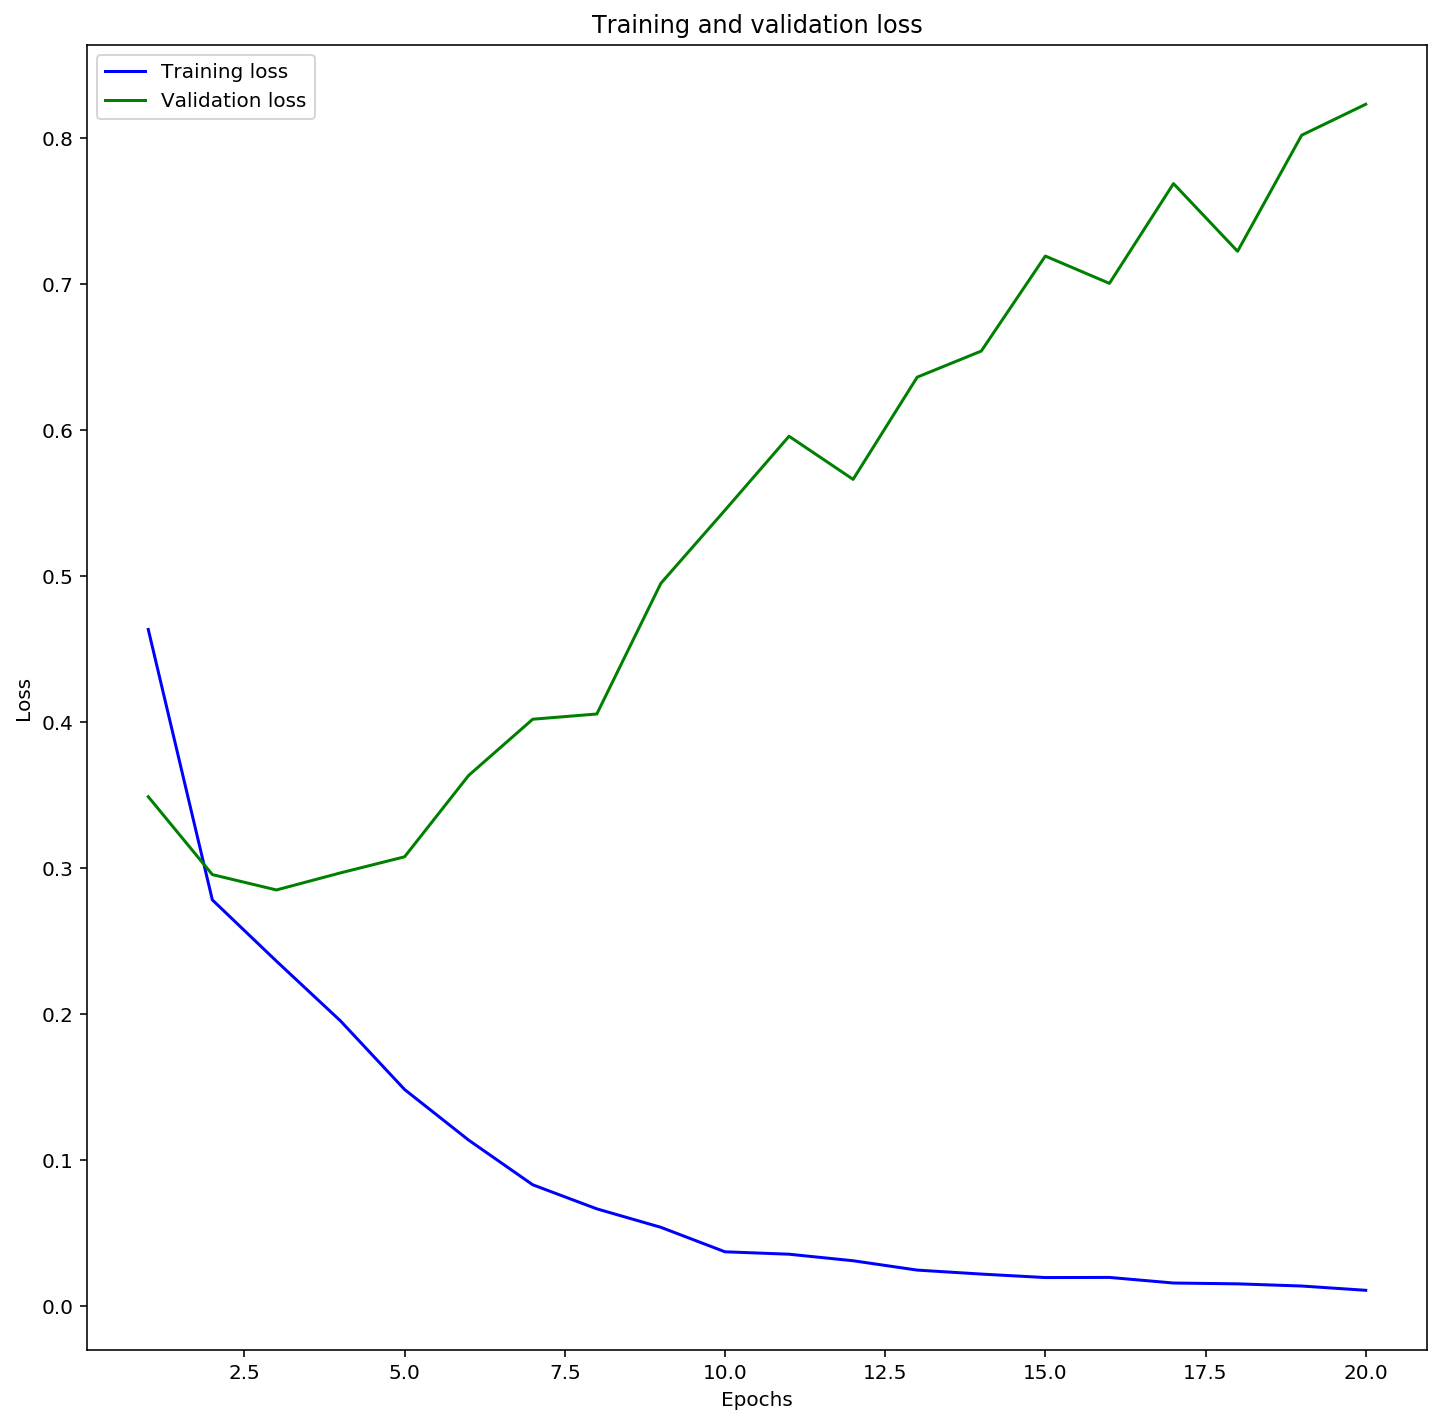

In [12]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

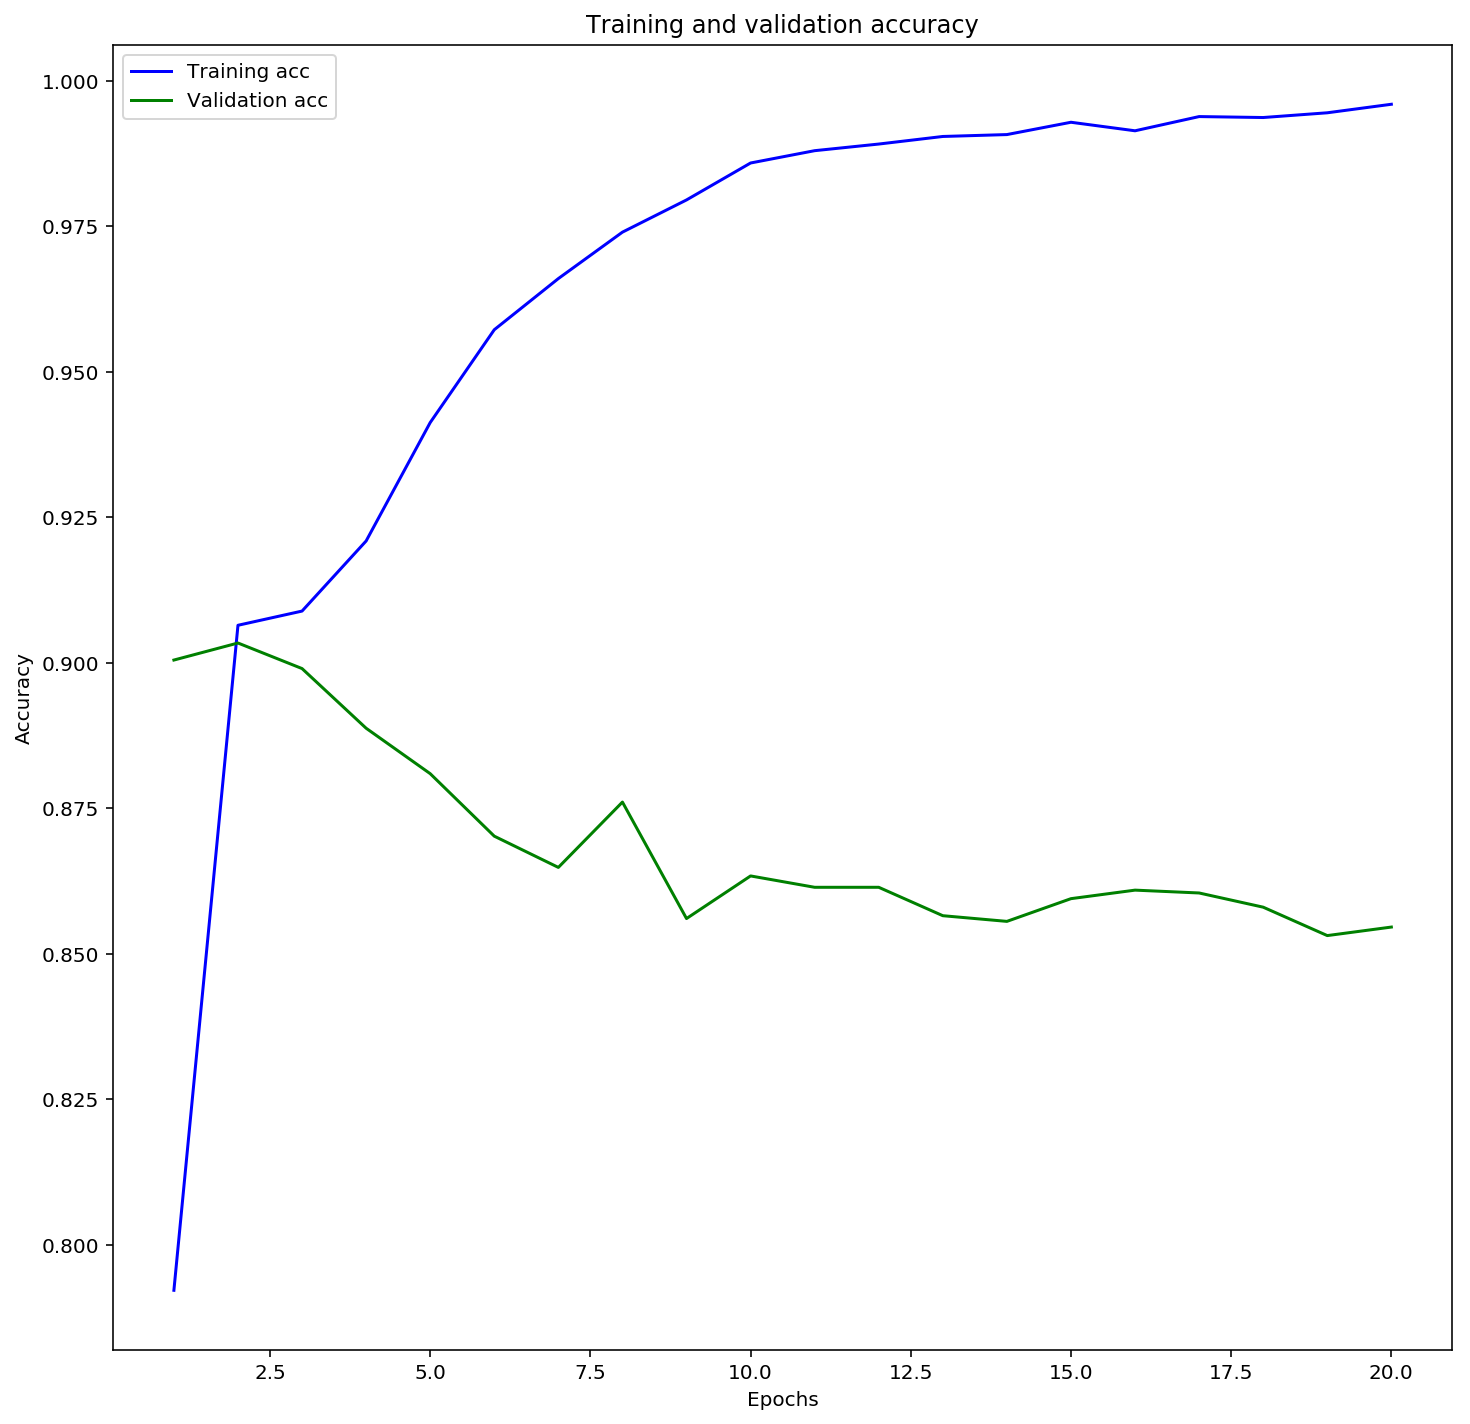

In [13]:
plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Predict labels on test data

In [14]:
predictedLabels = model.predict(x=[leftTableTestData, rightTableTestData])
predictedLabels = predictedLabels.argmax(axis=1)
testLabels = testLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

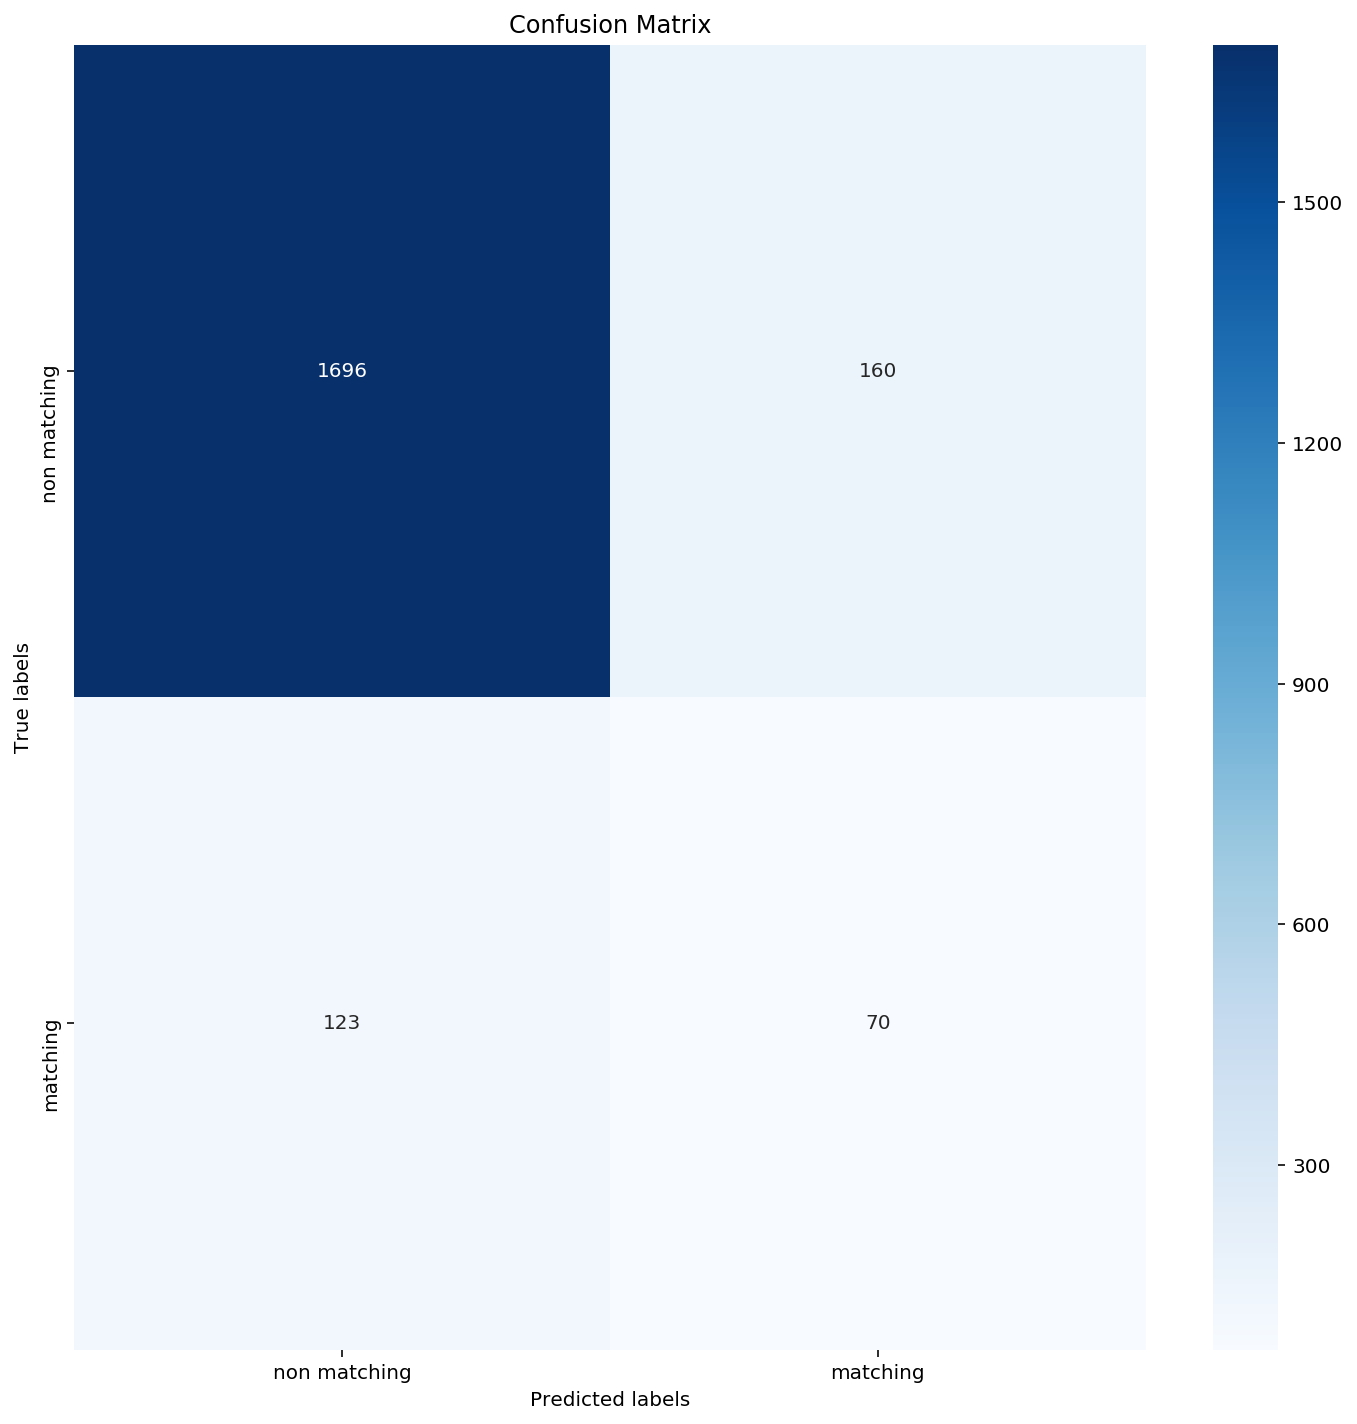

In [15]:
cm = confusion_matrix(testLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [16]:
precision, recall, fMeasure, support = precision_recall_fscore_support(testLabels, predictedLabels, average='binary')

if fMeasure is None:
    fMeasure = 0.0
if support is None:
    support = 0.0

row_format ="{:>15}" * 4
print(row_format.format('Precision', 'Recall', 'F-measure', 'Support'))
print(row_format.format(round(precision, 2), round(recall, 2), round(fMeasure,2), round(support, 2)))

      Precision         Recall      F-measure        Support
            0.3           0.36           0.33            0.0
